Add imports, define variables and load the dataset

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.mps.manual_seed(0)
np.random.seed(0)

BATCH_SIZE = 128
LOOKBACK_LENGTH = 14
TEST_LENGTH = 365
DROPOUT = 0.2
HIDDEN_SIZE = 256
NUM_LAYERS = 4
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
EPOCHS = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and sort the data
data = pd.read_csv("../data/BTC Data 2013-12-27 2025-04-01.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

print(f"Data range: {data['date'].min()} to {data['date'].max()}")
print(f"Total samples: {len(data)}")

Using device: cuda
Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114


Add extra features for cyclic trends in the Bitcoin history

In [88]:
data['dayOfWeek'] = data['date'].dt.dayofweek
data['dayOfMonth'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter
data['isWeekend'] = data['dayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

Normalize the dataset

In [89]:
feature_columns = ['open', 'high', 'low', 'volume', 'dayOfWeek', 'month']
target_column = 'close'

X = data[feature_columns].values
y = data[target_column].values.reshape(-1, 1)

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = X_scaler.fit_transform(X)
y_normalized = y_scaler.fit_transform(y)

Create custom dataset with the timeseries sequences

In [90]:
class TimeSeriesDataset(Dataset):
	def __init__(self, X, y):
		self.X = torch.FloatTensor(X)
		self.y = torch.FloatTensor(y)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, i):
		return self.X[i], self.y[i]

def create_sequences(X, y, seq_length):
	X_seq, y_seq = [], []
	
	for i in range(len(X) - seq_length):
		X_seq.append(X[i:i + seq_length])
		y_seq.append(y[i + seq_length])
		
	return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_normalized, y_normalized, LOOKBACK_LENGTH)

test_dates = data['date'].iloc[-TEST_LENGTH:]

train_dataset = TimeSeriesDataset(X_seq[:-TEST_LENGTH], y_seq[:-TEST_LENGTH])
test_dataset = TimeSeriesDataset(X_seq[-TEST_LENGTH:], y_seq[-TEST_LENGTH:])

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train samples: 3735
Test samples: 365


Create the model

In [91]:
class LSTMPrediction(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
		super(LSTMPrediction, self).__init__()

		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)

		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

model = LSTMPrediction(len(feature_columns), HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT).to(device)
print(model)

LSTMPrediction(
  (lstm): LSTM(6, 256, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


Load a pretrained model

In [92]:
#model.load_state_dict(torch.load("../weights/od_lstm-3l-256hs-0.2d-14lb-100e-ohlvdm.pth"))

Define loss function and training function with Adam optimizer

In [11]:
def train(model, train_loader, criterion, optimizer, epochs=EPOCHS):
	train_losses = []

	for epoch in range(epochs):
		model.train()
		train_loss = 0
		for X_batch, y_batch in train_loader:
			X_batch = X_batch.to(device)
			y_batch = y_batch.to(device)
	
			# Predict the output
			y_pred = model(X_batch)
			loss = criterion(y_pred, y_batch)

			# Reset gradients, calculate new ones and update model parameters
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			train_loss += loss.item()

		train_loss /= len(train_loader)
		train_losses.append(train_loss)
		print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

	return model, train_losses

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model, train_losses = train(model, train_loader, criterion, optimizer, EPOCHS)

KeyboardInterrupt: 

In [398]:
torch.save(model.state_dict(), f"../weights/od_lstm-{NUM_LAYERS}l-{HIDDEN_SIZE}hs-{DROPOUT}d-{LOOKBACK_LENGTH}lb-{EPOCHS}e-ohlvdm.pth")

In [93]:
model.load_state_dict(torch.load("../weights/od_lstm-4l-256hs-0.2d-14lb-75e-ohlvdm.pth"))

C:\Users\Hugo\AppData\Local\Temp\ipykernel_21592\1822408117.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../weights/od_lstm-4l-256hs

<All keys matched successfully>

Evaluate the model

In [94]:
def evaluate(model, test_loader, criterion):
	model.eval()
	test_loss = 0
	predictions = []
	truths = []

	with torch.no_grad():
		for X_batch, y_batch in test_loader:
			X_batch = X_batch.to(device)
			y_batch = y_batch.to(device)
	
			y_pred = model(X_batch)
			loss = criterion(y_pred, y_batch)

			test_loss += loss.item()

			# Add the predicted and actual values for plotting
			# Move to the CPU and convert the tensor to a numpy array
			predictions.append(y_pred.cpu().numpy())
			truths.append(y_batch.cpu().numpy())

	test_loss /= len(test_loader)

	predictions = np.concatenate(predictions, axis=0)
	truths = np.concatenate(truths, axis=0)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))

	#print(f"Train Loss: {train_losses[-1]:.6f}")
	print(f"Test Loss: {test_loss:.6f}")

	print("\nNormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	# Inverse the normalization to get the actual BTC prices
	predictions = y_scaler.inverse_transform(predictions)
	truths = y_scaler.inverse_transform(truths)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))
	print("\nUnnormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	return predictions, truths

predictions, actuals = evaluate(model, test_loader, criterion)


Test Loss: 0.002267

Normalized
MSE: 0.002223
RMSE: 0.047147
MAE: 0.036376
MAPE: 0.167677

Unnormalized
MSE: 6240294.000000
RMSE: 2498.058105
MAE: 1927.362305
MAPE: 0.025495


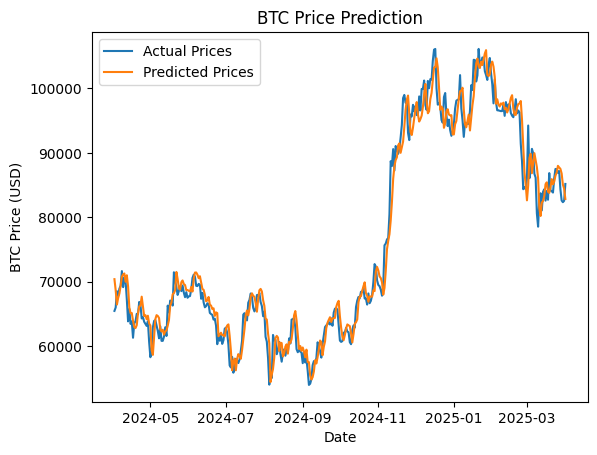

In [96]:
""" plt.plot(train_losses[2:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show() """

plt.plot(test_dates, actuals, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()